# Image classification TensorFlow

https://www.tensorflow.org/tutorials/images/classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load data

In [3]:
batch_size = 32
img_height = 480
img_width = 640

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  "ordered_data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
  "ordered_data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6627 files belonging to 3 classes.
Using 5302 files for training.
Found 6627 files belonging to 3 classes.
Using 1325 files for validation.


Looking at the classnames. We have 3 classes here as we know from that dataset. Numbers 0, 1 and 2. 0 for no people, 1 for some people and 2 for a lot of people.

In [5]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2']


## Visualize the data

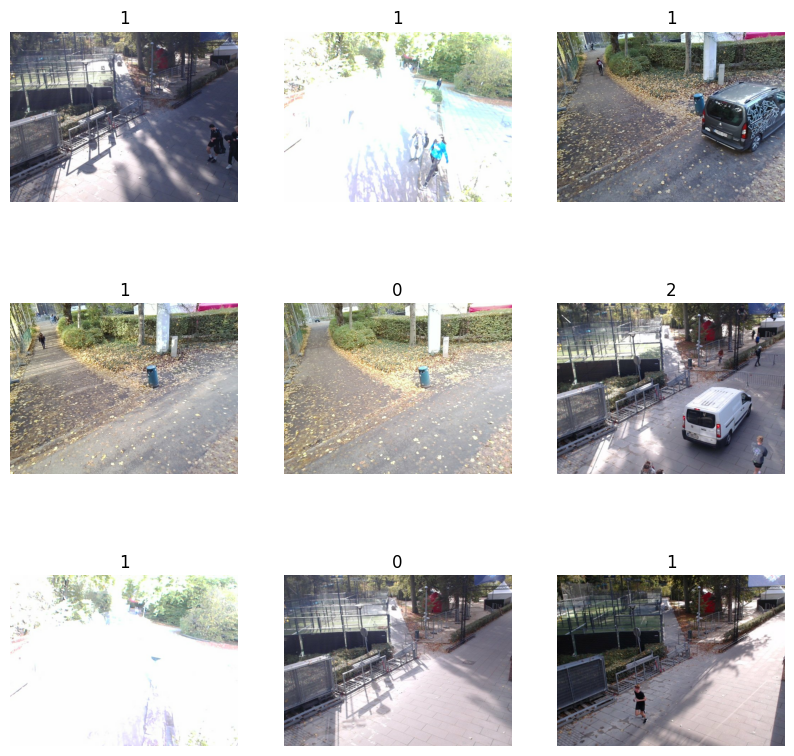

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 480, 640, 3)
(32,)


        The image_batch is a tensor of the shape (32, 480, 640, 3). This is a batch of 32 images of shape 480x640x3 (the last dimension refers to color channels RGB).
        The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

## Configure the dataset for performance

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. Standardize values to be in the `[0, 1]` range

In [9]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [10]:
# This code can sometimes crash the kernel. If it does, just run it again.
def normalize_data(x, y):
 return normalization_layer(x), y

normalized_ds = train_ds.map(normalize_data)

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment.

## Basic Keras model

### Create the model

The Keras Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. <br/>
There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. <br/>
To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [13]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 480, 640, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 240, 320, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 320, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 160, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 160, 64)     

```
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_1 (Rescaling)     (None, 640, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 640, 480, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 240, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 240, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 160, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 120, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 307200)            0         
                                                                 
 dense (Dense)               (None, 128)               39321728  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
=================================================================
Total params: 39,345,699
Trainable params: 39,345,699
Non-trainable params: 0
_________________________________________________________________
```

### Train the model

Train the model for 2 epochs with the Keras `Model.fit` method:

In [15]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
166/166 [==============================] - 741s 4s/step - loss: 1.0656 - accuracy: 0.6211 - val_loss: 0.5768 - val_accuracy: 0.7547
Epoch 2/5
166/166 [==============================] - 884s 5s/step - loss: 0.5090 - accuracy: 0.7920 - val_loss: 0.5484 - val_accuracy: 0.7713
Epoch 3/5
166/166 [==============================] - 703s 4s/step - loss: 0.3827 - accuracy: 0.8397 - val_loss: 0.5204 - val_accuracy: 0.7653
Epoch 4/5
166/166 [==============================] - 973s 6s/step - loss: 0.3111 - accuracy: 0.8746 - val_loss: 0.4635 - val_accuracy: 0.8060
Epoch 5/5
166/166 [==============================] - 990s 6s/step - loss: 0.2453 - accuracy: 0.8987 - val_loss: 0.4768 - val_accuracy: 0.7917


In [18]:
model.save("models/model")

INFO:tensorflow:Assets written to: models/model\assets


INFO:tensorflow:Assets written to: models/model\assets


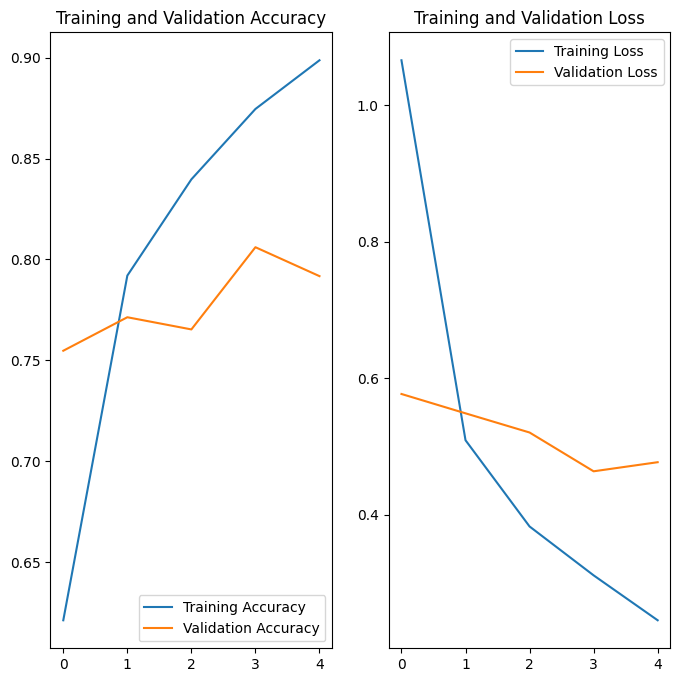

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the results of the model and graph, we can see that we have a very high training and validation accuracy.

Our validation loss is steadying out at around the 4th epoch but our training loss is still decreasing. This could mean that we are overfitting our model.